# Combine years

**Start to compare some of the trainings where we combine all of the years**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

import os
os.sys.path.append('../GraphNN/')
from preprocess import MDpT_cut,MDR_cut

os.sys.path.append('../Flow-Models/')
from densityEstimate import *
from densityPlots import *

os.sys.path.append('../code')
from eventDisplays import rainbow_text


# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Plan:** Let's have different hp configs that the nb can be run with, b/c I don't think I'm as interested in doing detail oriented hyperparameter scans anymore (right)???

In [2]:
hps = pd.DataFrame(0,range(5),['L','H','num_blocks','K','lr','beta','p'])

hps.iloc[0] = 10,32,1,4,1e-3,1e-6,.1

hps.iloc[1] = 10,64,2,4,1e-3,1e-6,.1

hps.iloc[2] = 10,32,2,4,1e-3,1e-3,.1 # low SR loss

hps.iloc[3] = 10,64,2,4,1e-3,1e-5,.1

hps.iloc[4] = 5,16,2,4,5e-4,1e-5,.2 # low SR loss


In [3]:
hps

L   H  num_blocks  K      lr      beta    p
0  10  32           1  4  0.0010  0.000001  0.1
1  10  64           2  4  0.0010  0.000001  0.1
2  10  32           2  4  0.0010  0.001000  0.1
3  10  64           2  4  0.0010  0.000010  0.1
4   5  16           2  4  0.0005  0.000010  0.2

Load in a dataset

In [10]:
yrShort = 18
subDir = f'data{yrShort}_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
colTag = '_'.join(cols)
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d18 = data(5, yrShort, prodTag, tag, ntag, s)

mask = (d18.df.abs_deta_hh < 1.5)  
d18.mlPrepare(mask,cols,N=-1)


../data/data18_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 94075 events from 94075 available for the training / validation set


Load in some histograms

In [6]:
i_hp = 0

L,H,nb,K,lr,beta,dpt = hps.iloc[i_hp]

In [11]:
modelDir = f'../Flow-Models/models/{subDir}_SM_2b_p_0.01_2b_detaCut/'
modelDir += f'nsf_rq-coupling_{colTag}_lu_{int(L)}_layers_H_{int(H)}_{int(nb)}_blocks_K_{int(K)}_B_3_lr_{lr}_{beta}_p{dpt}_iter0'

hists=[]
for md,ti in zip([modelDir,modelDir.replace(str(yrShort),'161718'),modelDir+'_data161718'],
                 ['','_18','_data161718']):
    
    histFile = os.path.join(md,f'hists1d{ti}.json')
    print(histFile)
    with open(histFile, 'r') as varfile:
        out = json.load(varfile)

    # Go from lists -> np.arrays and append to the hists
    for k in out.keys():
        out[k] = np.array(out[k])

    hists.append(out)

../Flow-Models/models/data18_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d.json
../Flow-Models/models/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d_18.json
../Flow-Models/models/data18_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0_data161718/hists1d_data161718.json


In [40]:
modelDir

'../Flow-Models/models/data18_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0'

In [12]:
len(hists)

3

Make some plots!!!

In [16]:
myVars = ['m_hh','m_hh_cor2','abs_deta_hh','absCosThetaStar',
          'pT_h1', 'pT_h2', 'eta_h1', 'eta_h2', 'dphi_hh']

bins = 50
myRanges = [(200,1200),(250,1250),(0,1.75),(0,1),
            (0,400),(0,400),(-3,3),(-3,3),(-.5,np.pi)]

varLabels = ['$m_{hh}$ [GeV]','$m_{hh}^{cor,2}$ [GeV]',
             '$|\Delta \eta_{hh}|$','$|\cos \Theta *|$',
             '$p_T^{h1}$','$p_T^{h2}$','$\eta_{h1}$','$\eta_{h2}$','$\Delta \Phi_{hh}$']

**Let's try to get some of this plotting functionality up and running!!**

In [18]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += f"20{yrShort} data FEB2020 MNT prod\n"
text += "DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM},|\Delta \eta_{hh}|$ < 1.5"

In [34]:
betaStr = r'$\beta$'

title = f'NSF: L={L:.0f}, H={H:.0f}, {nb:.0f} block, lr={lr:.0e}, {betaStr}={beta:.0e}, p={dpt}'
title

'NSF: L=10, H=32, 1 block, lr=1e-03, $\\beta$=1e-06, p=0.1'

In [43]:
figDir18 = os.path.join('figures',*modelDir.split('/')[3:])
if not os.path.exists(figDir18):
    os.mkdir(figDir18)

figDir18 += '/trainAll'
if not os.path.exists(figDir18):
    os.mkdir(figDir18)
figDir18

'figures/data18_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/trainAll'

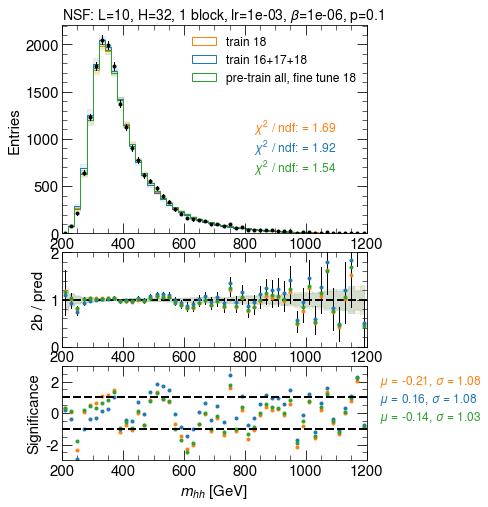

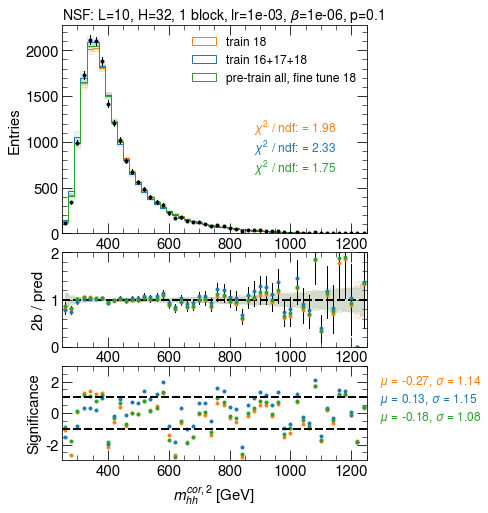

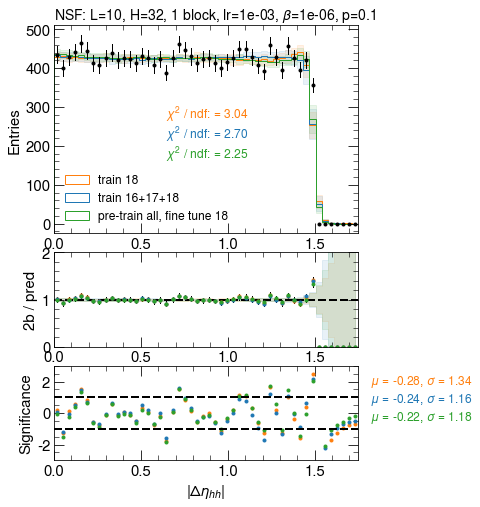

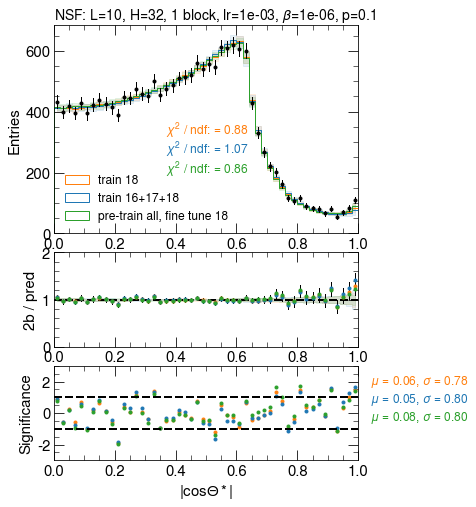

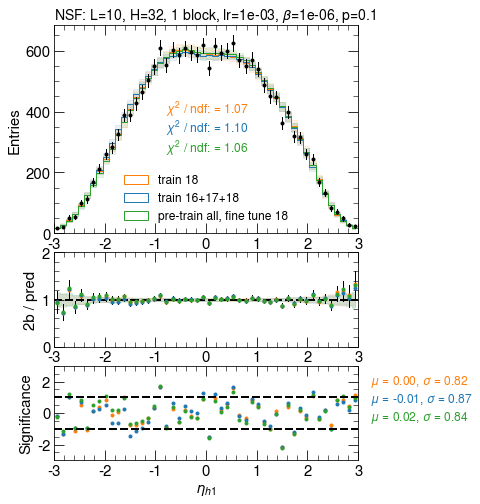

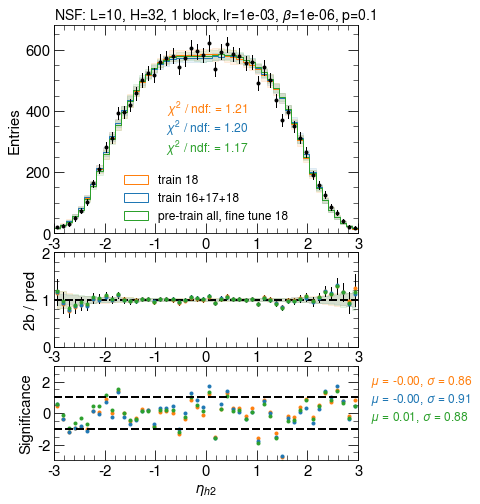

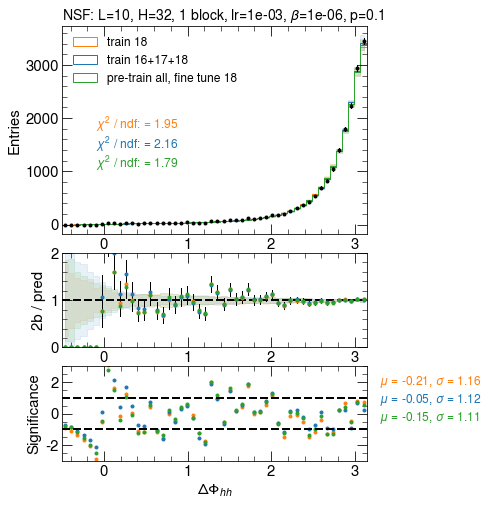

In [45]:
mask = (d18.df.abs_deta_hh < 1.5) & (d18.df.kinematic_region==0)

for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d18.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for i,color,l in zip([0,1,2],['C1','C0','C2'] ,#['darkorange','dodgerblue','green'],
                         [f'train {yrShort}','train 16+17+18',f'pre-train all, fine tune {yrShort}']):
        
        nom,std = hists[i][f'{c}_mean'],hists[i][f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)
    
    ax1.set_title(title,loc='left',fontsize=14)
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{figDir18}/{c}_SR.pdf',bbox_inches='tight')
    #break

## And now for 2017

In [47]:
yrShort = 17
subDir17 = f'data{yrShort}_PFlow-FEB20-5jets'

d17 = data(5, yrShort, prodTag, tag, ntag, s)

mask = (d17.df.abs_deta_hh < 1.5)  
d17.mlPrepare(mask,cols,N=-1)

../data/data17_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 43161 events from 43161 available for the training / validation set


In [50]:
mDir17 = f'../Flow-Models/models/{subDir17}_SM_2b_p_0.01_2b_detaCut/'
mDir17 += f'nsf_rq-coupling_{colTag}_lu_{int(L)}_layers_H_{int(H)}_{int(nb)}_blocks_K_{int(K)}_B_3_lr_{lr}_{beta}_p{dpt}_iter0'

hists17=[]
for md,ti in zip([mDir17,mDir17.replace('17','161718'),mDir17+'_data161718'],
                 ['','_17','_data161718']):
    
    histFile = os.path.join(md,f'hists1d{ti}.json')
    print(histFile)
    with open(histFile, 'r') as varfile:
        out = json.load(varfile)

    # Go from lists -> np.arrays and append to the hists
    for k in out.keys():
        out[k] = np.array(out[k])

    hists17.append(out)

../Flow-Models/models/data17_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d.json
../Flow-Models/models/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d_17.json
../Flow-Models/models/data17_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0_data161718/hists1d_data161718.json


In [51]:
figDir17 = os.path.join('figures',*mDir17.split('/')[3:])
if not os.path.exists(figDir17):
    os.mkdir(figDir17)

figDir17 += '/trainAll'
if not os.path.exists(figDir17):
    os.mkdir(figDir17)
figDir17

'figures/data17_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/trainAll'

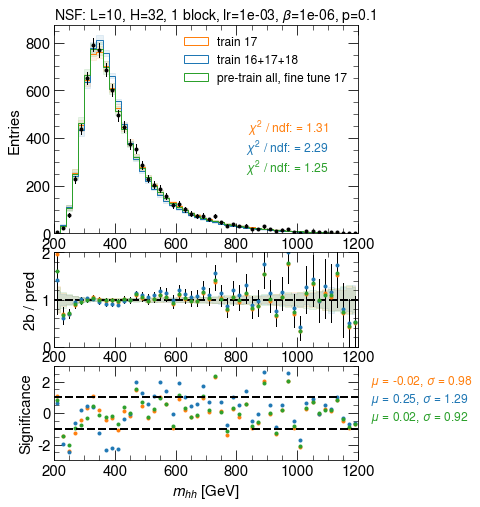

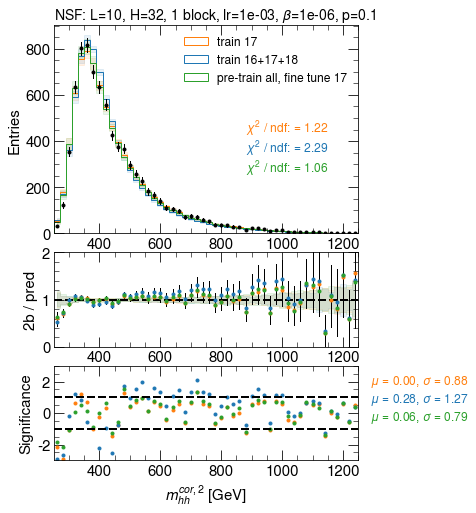

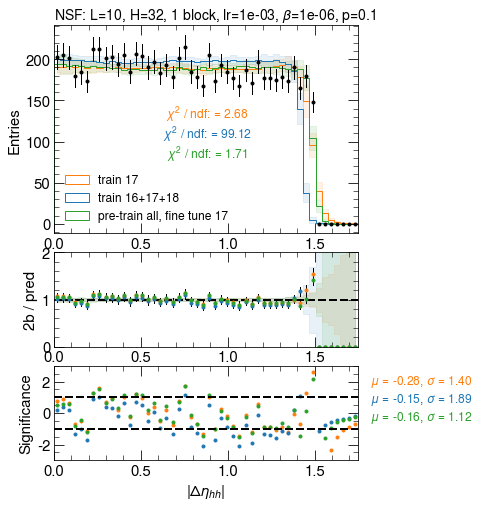

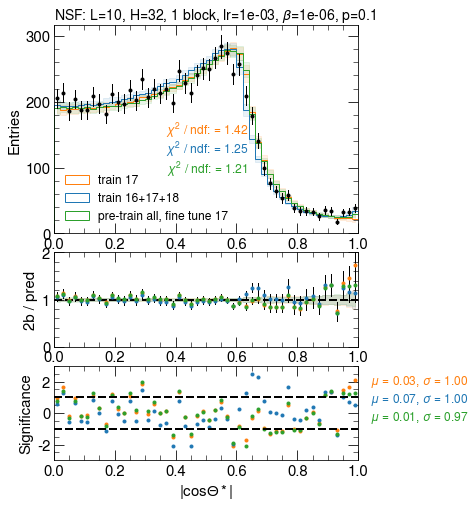

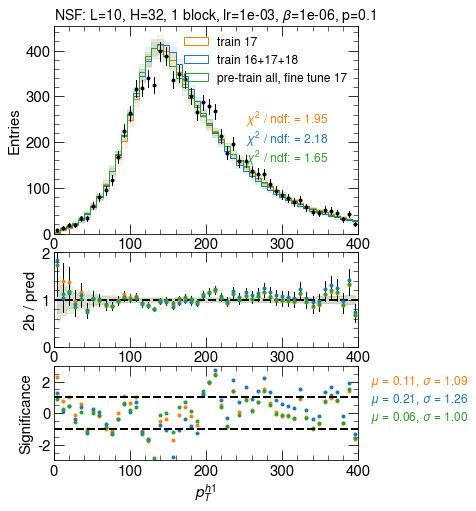

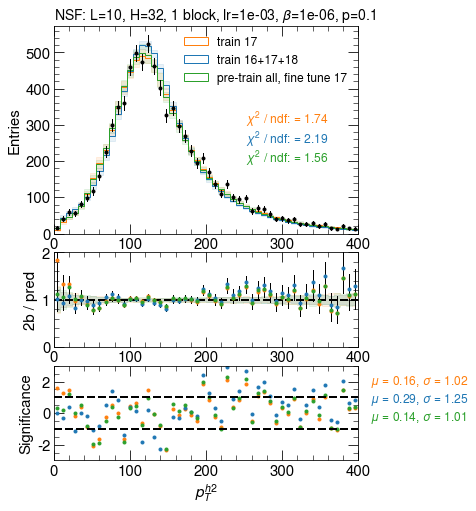

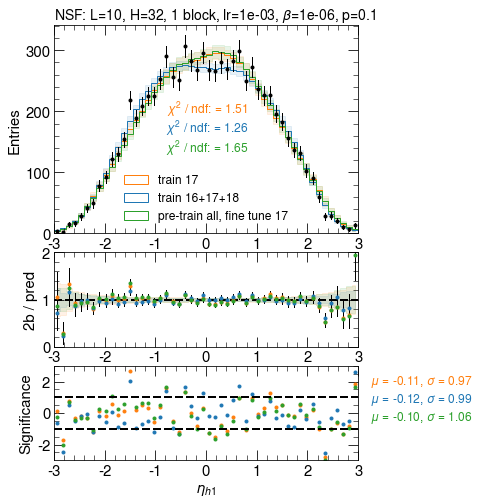

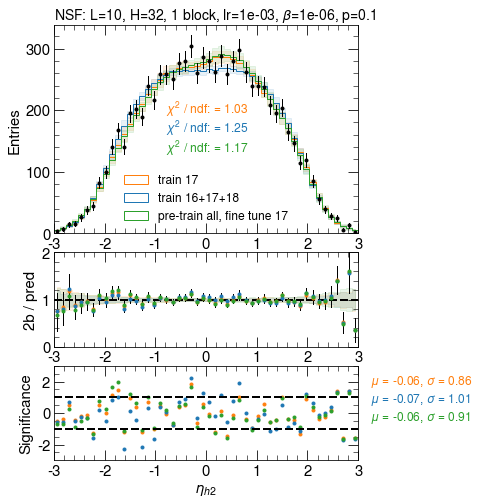

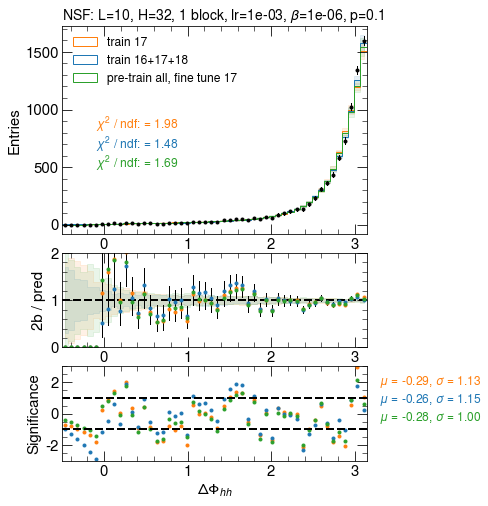

In [52]:
mask = (d17.df.abs_deta_hh < 1.5) & (d17.df.kinematic_region==0)

for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d17.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for i,color,l in zip([0,1,2],['C1','C0','C2'] ,#['darkorange','dodgerblue','green'],
                         [f'train 17','train 16+17+18',f'pre-train all, fine tune 17']):
        
        nom,std = hists17[i][f'{c}_mean'],hists17[i][f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)
    
    ax1.set_title(title,loc='left',fontsize=14)
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{figDir17}/{c}_SR.pdf',bbox_inches='tight')
    #break

## Finally for 2016

In [49]:
yrShort = 16
subDir16 = f'data{yrShort}_PFlow-FEB20-5jets'

d16 = data(5, yrShort, prodTag, tag, ntag, s)

mask = (d16.df.abs_deta_hh < 1.5)  
d16.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


In [56]:
mDir16 = f'../Flow-Models/models/{subDir16}_SM_2b_p_0.01_2b_detaCut/'
mDir16 += f'nsf_rq-coupling_{colTag}_lu_{int(L)}_layers_H_{int(H)}_{int(nb)}_blocks_K_{int(K)}_B_3_lr_{lr}_{beta}_p{dpt}_iter0'

hists16=[]
for md,ti in zip([mDir16,mDir16.replace('16','161718'),mDir16+'_data161718'],
                 ['','_16','_data161718']):
    
    histFile = os.path.join(md,f'hists1d{ti}.json')
    print(histFile)
    with open(histFile, 'r') as varfile:
        out = json.load(varfile)

    # Go from lists -> np.arrays and append to the hists
    for k in out.keys():
        out[k] = np.array(out[k])

    hists16.append(out)

../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d.json
../Flow-Models/models/data161718_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/hists1d_16.json
../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0_data161718/hists1d_data161718.json


In [57]:
figDir16 = os.path.join('figures',*mDir16.split('/')[3:])
if not os.path.exists(figDir16):
    os.mkdir(figDir16)

figDir16 += '/trainAll'
if not os.path.exists(figDir16):
    os.mkdir(figDir16)
figDir16

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0/trainAll'

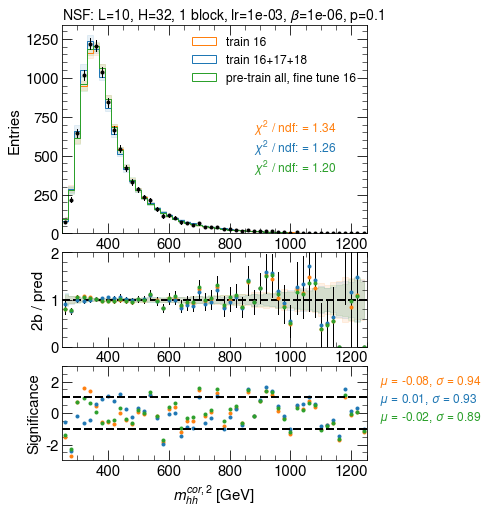

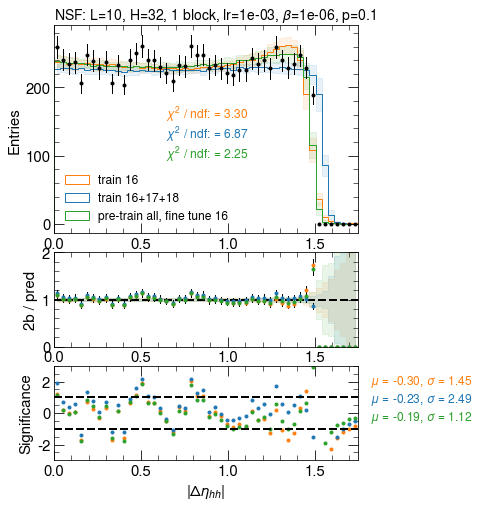

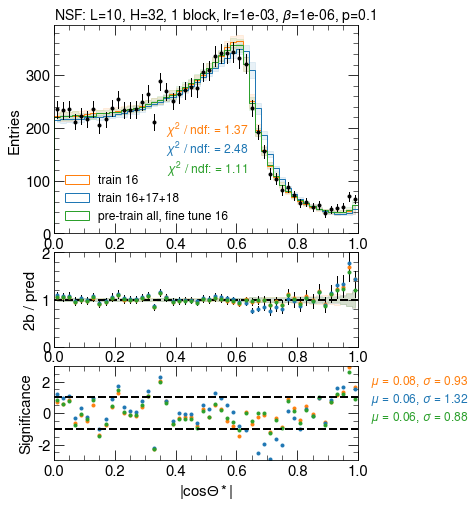

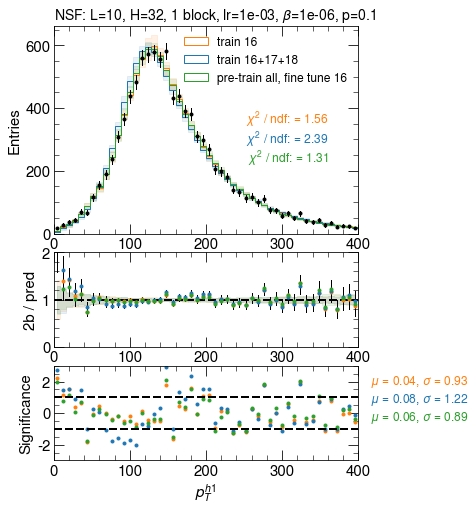

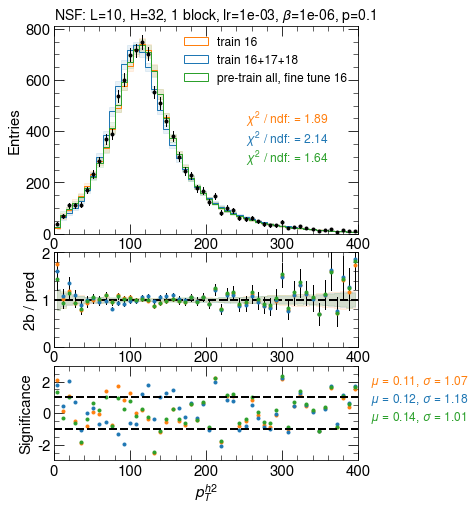

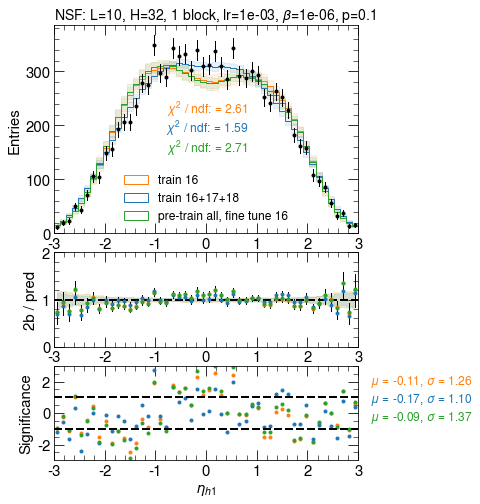

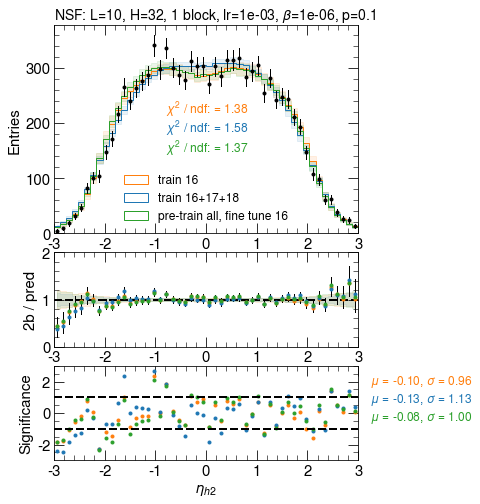

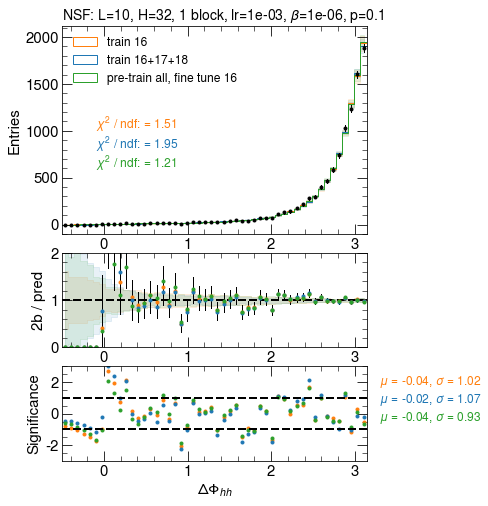

In [58]:
mask = (d16.df.abs_deta_hh < 1.5) & (d16.df.kinematic_region==0)

for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                              [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                              ['right','right','center','center','right','right','center','center','left'],
                              ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d16.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for i,color,l in zip([0,1,2],['C1','C0','C2'] ,
                         [f'train 16','train 16+17+18',f'pre-train all, fine tune 16']):
        
        nom,std = hists16[i][f'{c}_mean'],hists16[i][f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=l)
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        X2 = chisquare(n_2b,nom)[0]
        ls.append(f'$\chi^2$ / ndf: = {X2/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12)
    
    ax1.set_title(title,loc='left',fontsize=14)
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{figDir16}/{c}_SR.pdf',bbox_inches='tight')
    #break

**Q: Are there any of these plots that would be useful to overlay on top of each other between the years??**